# Model performance comparison with CPU
In this notebook the computational cost performance will be evaluated between the CNN and transformer models using the test data and a CPU to process the inference.

In [1]:
from tensorflow import keras
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os

## Hardware information

In [2]:
# CPU
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
addres

## Load the test data

In [3]:
# Load the dataset from the working directory
x_test = np.genfromtxt('./X_test.csv', delimiter=",")
y_test = np.genfromtxt('./y_test.csv', delimiter=",").astype(int)

## Evaluate inference time
The inference time will be measured with the test data 10 times for each model to account for any random variations

In [4]:
# Function to calculate inference time for N iterations
def model_inference_time(model, iterations=10):
  elapsed = []

  for i in range(iterations):
    start = time.perf_counter()
    y_pred = model.predict(x_test)
    elapsed.append(time.perf_counter() - start)

  return elapsed


# Load models
model_CNN = keras.models.load_model('best_model_CNN.h5')
model_transformer = keras.models.load_model('best_model_Transformer.h5')

# Calculate inference time
n_iterations = 10

cnn_test_inference_time = np.array(model_inference_time(model_CNN, n_iterations))
transformer_test_inference_time = np.array(model_inference_time(model_transformer, n_iterations))

# Create dataframe with for plotting
cnn_df = pd.DataFrame()
cnn_df['iteration'] = [i for i in range(n_iterations)]
cnn_df['time_test'] = cnn_test_inference_time * 1000 # Time in milisenconds
cnn_df['time_single'] = cnn_test_inference_time * 1000 / x_test.shape[0] # Time in milisenconds
cnn_df['model'] = ['CNN' for i in range(n_iterations)]
cnn_df['hardware'] = ['CPU' for i in range(n_iterations)]

transformer_df = pd.DataFrame()
transformer_df['iteration'] = [i for i in range(n_iterations)]
transformer_df['time_test'] = transformer_test_inference_time * 1000 # Time in milisenconds
transformer_df['time_single'] = transformer_test_inference_time * 1000 / x_test.shape[0] # Time in milisenconds
transformer_df['model'] = ['Transformer' for i in range(n_iterations)]
transformer_df['hardware'] = ['CPU' for i in range(n_iterations)]

inference_time_df = pd.concat([cnn_df, transformer_df])

5/5 [==============================] - 4s 855ms/step


In [5]:
# Save the results to disk and show them
inference_time_df.to_pickle('inference_time_CPU.pkl')
inference_time_df

,iteration,time_test,time_single,model,hardware
0,0,628.866177,4.428635,CNN,CPU
1,1,116.223676,0.818477,CNN,CPU
2,2,198.667454,1.399067,CNN,CPU
3,3,198.116655,1.395188,CNN,CPU
4,4,202.948575,1.429215,CNN,CPU
5,5,118.014531,0.831088,CNN,CPU
6,6,118.658442,0.835623,CNN,CPU
7,7,117.578707,0.828019,CNN,CPU
8,8,136.601650,0.961983,CNN,CPU
9,9,199.825217,1.407220,CNN,CPU


## Results with all iterations

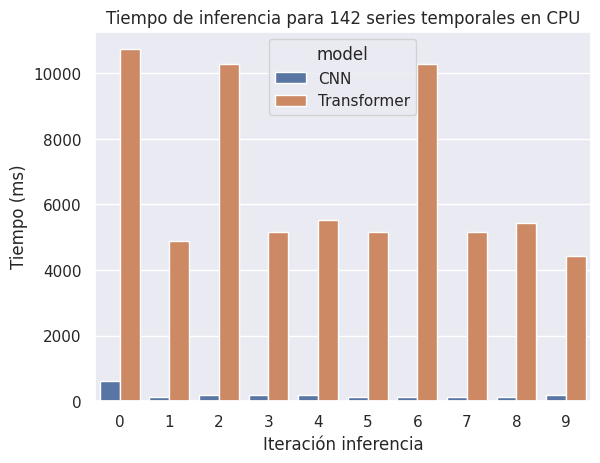

In [6]:
# Barplot for the test dataset
sns.barplot(data=inference_time_df, x='iteration', y='time_test', hue='model')
# Labels
plt.title(f'Tiempo de inferencia para {x_test.shape[0]} series temporales en CPU')
plt.xlabel('Iteración inferencia')
plt.ylabel('Tiempo (ms)')
# Save figure
plt.savefig('barplot inference time test all iterations CPU.png')

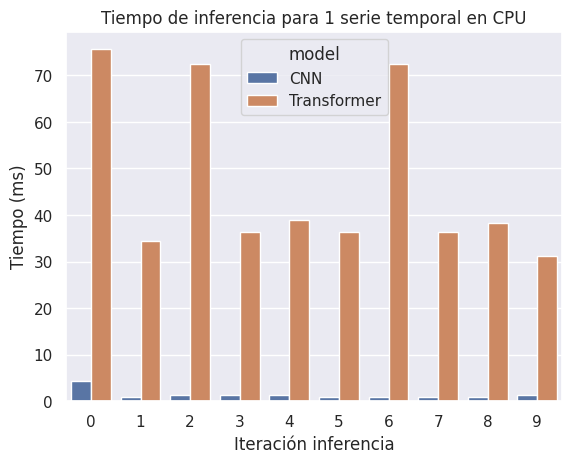

In [7]:
# Barplot for a single series
sns.barplot(data=inference_time_df, x='iteration', y='time_single', hue='model')
# Labels
plt.title('Tiempo de inferencia para 1 serie temporal en CPU')
plt.xlabel('Iteración inferencia')
plt.ylabel('Tiempo (ms)')
# Save figure
plt.savefig('barplot inference time single all iterations CPU.png')

## Results without the first inference
A modern GPU device can exist in one of several different power states. When the GPU is not being used for any purpose and persistence mode (i.e., which keeps the GPU on) is not enabled, the GPU will automatically reduce its power state to a very low level, sometimes even a complete shutdown. In lower power state, the GPU shuts down different pieces of hardware, including memory subsystems, internal subsystems, or even compute cores and caches.

The invocation of any program that attempts to interact with the GPU will cause the driver to load and/or initialize the GPU. This driver load behavior is noteworthy. Applications that trigger GPU initialization can incur up to 3 seconds of latency, due to the scrubbing behavior of the error correcting code.
[Reference](https://deci.ai/blog/measure-inference-time-deep-neural-networks/)

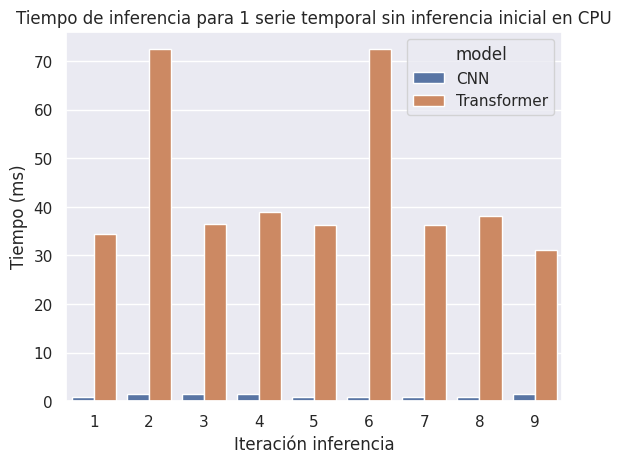

In [8]:
# Barplot for a single series
sns.barplot(data=inference_time_df[inference_time_df['iteration']!=0], x='iteration', y='time_single', hue='model')
# Labels
plt.title('Tiempo de inferencia para 1 serie temporal sin inferencia inicial en CPU')
plt.xlabel('Iteración inferencia')
plt.ylabel('Tiempo (ms)')
# Save figure
plt.savefig('barplot inference time single without first iteration CPU.png')

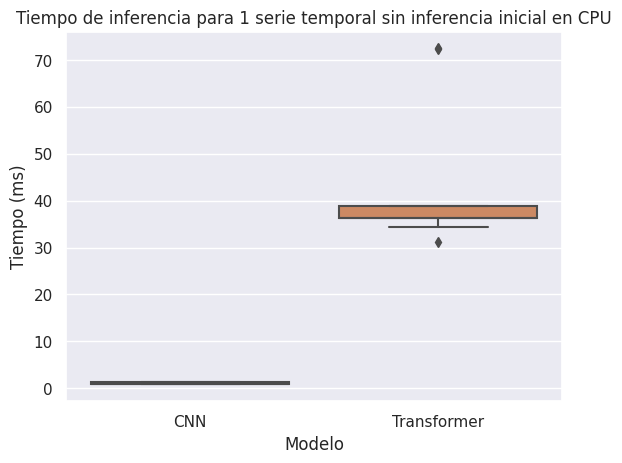

In [9]:
# Box plot without the first iteration
sns.boxplot(data=inference_time_df[inference_time_df['iteration']!=0], x='model', y='time_single')
# Labels
plt.title('Tiempo de inferencia para 1 serie temporal sin inferencia inicial en CPU')
plt.xlabel('Modelo')
plt.ylabel('Tiempo (ms)')
# Save figure
plt.savefig('boxplot inference time single without first iteration CPU.png')